In [1]:
import os
import pandas as pd
import numpy as np
import json
import subprocess
from Bio import SeqIO
import plotnine
import dask
from dask import delayed
from dask.distributed import Client
from itertools import combinations
import difflib
import scipy
import random
import pysais
from difflib import SequenceMatcher
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import ahocorasick
from ahocorasick import Automaton
import sys

### Set up functions

In [2]:
def lenset(input_list):
    return len(set(input_list))

def polish_input_frame(input_dir,cluster_threshold,kmer_no,sample_id,sample_code):
    curr_concat_read_in=pd.read_csv(os.path.join(input_dir,sample_id+"_kmerlen_"+str(kmer_no)+\
                                    "_dist_"+str(cluster_threshold)+"_"+str(sample_code)+".progress.csv"))

    curr_concat_read_in["sample_code"] = [1 if sample_id in curr else 0 for curr in \
                                  list(curr_concat_read_in.Source_ID)]
    tester_curr=curr_concat_read_in.groupby(["cluster_blob","HomClust"])[["Division","Domain","Family","Class","sample_code","Genus","Species"]].\
        agg([set,lenset,len,sum]).reset_index()
    tester_curr.columns = tester_curr.columns.map('|'.join).str.strip('|')
    
    merged_w_eukulele=merged_eukulele.merge(curr_concat_read_in.\
                                  rename({"Source_ID":"Revised_name"},
                                         axis="columns")[["Revised_name","HomClust",
                                                          "cluster_blob"]].\
                                            merge(tester_curr),
                left_on="Revised_name",right_on="Revised_name",how="outer")
    
    return curr_concat_read_in,tester_curr,merged_w_eukulele

def build_upset_df(tester_curr,cluster_threshold):
    
    to_check=tester_curr.loc[[(("Rhizosoleniaceae" in curr)|("Skeletonemataceae" in curr)|\
                              ("Thalassiosiraceae" in curr)|("Hemiaulaceae" in curr))&\
                             (np.nan in curr) for curr in tester_curr["Family|set"]]]

    all_set=set()
    #for curr in to_check["Family|set"]:
    #    all_set.update(curr)
    #all_list_set = list(all_set)
    all_list_set = list(set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                    "Thalassiosiraceae"])) #+ list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"]))))#[curr.strip() for curr in list(all_set)]

    all_ochrophyte=list(set(tax_table.loc[tax_table.Division=="Ochrophyta","Family"]))
    build_upset_df = pd.DataFrame()
    counter = 0
    for curr in range(len(to_check.index)):
        curr_df = pd.DataFrame()
        for curr_tax in all_list_set:
            curr_tax_label=curr_tax
            if curr_tax != curr_tax:
                curr_tax_label = "Sample_NB"
            if curr_tax in to_check.iloc[curr].loc["Family|set"]:
                curr_df[curr_tax_label] = [True]
            else:
                curr_df[curr_tax_label] = [False]
        curr_df["number_seqs"] = to_check.iloc[curr].loc["sample_code|sum"]
        if len(to_check.iloc[curr].loc["Family|set"].difference(all_list_set)) > 1:
            curr_df["non-diatom"] = [True]
        else:
            curr_df["non-diatom"] = [False]

        if len(to_check.iloc[curr].loc["Family|set"].difference(all_ochrophyte)) > 1:
            curr_df["non-ochrophyte"] = [True]
        else:
            curr_df["non-ochrophyte"] = [False]

        if len(to_check.iloc[curr].loc["Domain|set"].difference(set(["Eukaryota",np.nan]))) > 0:
            curr_df["non-eukaryote"] = [True]
        else:
            curr_df["non-eukaryote"] = [False]
        build_upset_df = pd.concat([build_upset_df,curr_df])
        #if counter > 100:
        #    break
        counter=counter+1
    non_target_diatom=list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"])-
     set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae","Thalassiosiraceae",
          "Stephanodiscaceae","Chaetocerotales"]))
    build_upset_df["other_diatom"]=build_upset_df[non_target_diatom].any(axis=1)

    build_upset_df = build_upset_df.loc[:,~build_upset_df.columns.duplicated()].copy().\
        groupby(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                 "Thalassiosiraceae","Stephanodiscaceae","Chaetocerotales"]+\
                ["non-diatom","non-eukaryote","non-ochrophyte","other_diatom"])\
        ["number_seqs"].sum()
    
    build_upset_df["Dist"] = cluster_threshold
    return build_upset_df
                            
def aggset(input_set):
    if input_set!=input_set:
        return "NoDeepClustWTarget"
    return("_".join(sorted(list(set([str(curr) for curr in input_set if curr==curr])))))
                            
def returnagg(merged_eukulele):
    merged_eukulele["Family|agg"] = [aggset(curr) for curr in merged_eukulele["Family|set"]]
    merged_eukulele["Division|agg"] = [aggset(curr) for curr in merged_eukulele["Division|set"]]

    return merged_eukulele[["Family|agg","Family|lenset","Division","Domain","Family","Family|set",
                          "Division|set","Class|set","transcript_name"]]

tax_table=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/output/tara-eukulele-mapping/EUKulele_databases/marmmetsp_all_phaeo/tax-table.txt",sep="\t")
haptophyte_genera=list(set(tax_table.loc[tax_table.Division=="Haptophyta","Genus"]))

def check_in_haptophyta(list_genera):
    if not "Phaeocystis" in list_genera:
        return False
    for curr_genus in list_genera:
        if not curr_genus in haptophyte_genera:
            return False
        
    return True

### Read in EUKulele databases

In [3]:
EUKulele_MAD_cds_marmmetsp=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/output/tara-eukulele-mapping/EUKulele_assembly_mapping/SO-all-SRF-0.8-5.00/phaeo_all/taxonomy_estimation/proteins-estimated-taxonomy.out",
                                            sep="\t")

import time
import itertools
original_fasta = "/vortexfs1/omics/alexander/data/TARA/PRJEB4352-snakmake-output/prodigal/SO-all-SRF-0.8-5.00/proteins.faa"
behaved_fasta = "phaeo_fasta_file.fasta"
os.system(" ".join(["bash","/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/remove_newlines.sh",original_fasta,">",behaved_fasta]))

counter=1
start_time=time.time()
sequence_dict=dict()
with open(behaved_fasta,"r") as f:
    counter=1
    for line1,line2 in itertools.zip_longest(*[f]*2):
        sequence_dict[line1.split(">")[1].split(" ")[0]]=line2
        #if counter > 2000000:
        #    break
        counter=counter+1
    print(time.time()-start_time)
    
all_sequences_nb=pd.DataFrame({"transcript_name":list(sequence_dict.keys())})

merged_eukulele=EUKulele_MAD_cds_marmmetsp.merge(all_sequences_nb,how="outer")
merged_eukulele[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele["transcript_name"]]

2.9385273456573486


In [4]:
EUKulele_MAD_cds_marmmetsp=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/output/tara-eukulele-mapping/EUKulele_assembly_mapping/SO-all-SRF-0.8-5.00/colonies_phaeo/taxonomy_estimation/proteins-estimated-taxonomy.out",
                                            sep="\t")

merged_eukulele_colony=EUKulele_MAD_cds_marmmetsp.merge(all_sequences_nb,how="outer")
merged_eukulele_colony[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele_colony.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele_colony["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele_colony["transcript_name"]]

EUKulele_MAD_cds_marmmetsp=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/output/tara-eukulele-mapping/EUKulele_assembly_mapping/SO-all-SRF-0.8-5.00/free_phaeo/taxonomy_estimation/proteins-estimated-taxonomy.out",
                                            sep="\t")

merged_eukulele_free=EUKulele_MAD_cds_marmmetsp.merge(all_sequences_nb,how="outer")
merged_eukulele_free[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele_free.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele_free["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele_free["transcript_name"]]

In [5]:
tax_table=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/output/tara-eukulele-mapping/EUKulele_databases/marmmetsp_all_phaeo/tax-table.txt",sep="\t")
hapto_mmetsps=list(tax_table.loc[tax_table.Division.isin(["Haptophyta"]),"Source_ID"])

### Read in tax-aliquots information

In [6]:
%%time
curr_concat_read_in0_5_hapto,tester_curr0_5_hapto,merged_w_eukulele0_5_hapto=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots/",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=3,sample_id="k",sample_code="phaeoprymnes")

CPU times: user 17min 50s, sys: 27.9 s, total: 18min 18s
Wall time: 18min 20s


In [7]:
merged_w_eukulele0_5_hapto.head()

,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Domain,Division,...,sample_code|len,sample_code|sum,Genus|set,Genus|lenset,Genus|len,Genus|sum,Species|set,Species|lenset,Species|len,Species|sum
0,0.0,k119_100014_1,family,Eukaryota; Stramenopiles; Ochrophyta; Bacillar...,Bacillariaceae,235.71,0.0,NaN,Eukaryota,Stramenopiles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,k119_100057_1,family,Bacteria; Proteobacteria; Alphaproteobacteria;...,Rhodobacteraceae,608.19,0.0,NaN,Bacteria,Proteobacteria,...,4.0,1.0,"{nan, Roseibacterium, Octadecabacter, Jannaschia}",4.0,4.0,JannaschiaOctadecabacterRoseibacterium,"{nan, Jannaschia sp. CCS1, Roseibacterium elon...",4.0,4.0,Jannaschia sp. CCS1Octadecabacter antarcticusR...
2,0.0,k119_100077_1,genus,Bacteria; Proteobacteria; Gammaproteobacteria;...,Paraglaciecola,332.71,0.0,NaN,Bacteria,Proteobacteria,...,2.0,2.0,{nan},1.0,2.0,0,{nan},1.0,2.0,0
3,0.0,k119_10008_1,genus,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyc...,Phaeocystis,60.14,1.0,NaN,Eukaryota,Hacrobia,...,11.0,3.0,"{nan, Phaeocystis, Pinguiococcus}",3.0,11.0,PhaeocystisPinguiococcusPhaeocystisPhaeocystis...,"{nan, Phaeocystis pouchetii, Phaeocystis antar...",6.0,11.0,Phaeocystis cordataPinguiococcus pyrenoidosusP...
4,0.0,k119_100090_1,genus,Eukaryota; Stramenopiles; Ochrophyta; Pelagoph...,Aureococcus,549.02,0.0,NaN,Eukaryota,Stramenopiles,...,2.0,2.0,{nan},1.0,2.0,0,{nan},1.0,2.0,0


### Format tax-aliquots frame

In [8]:
merged_w_eukulele0_5_hapto["Family|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Family|set"]]
merged_w_eukulele0_5_hapto.loc[merged_w_eukulele0_5_hapto.Genus=="Phaeocystis"].groupby("Family|agg").count().\
    reset_index().sort_values("transcript_name",ascending=False)

,Family|agg,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Domain,...,sample_code|len,sample_code|sum,Genus|set,Genus|lenset,Genus|len,Genus|sum,Species|set,Species|lenset,Species|len,Species|sum
463,Phaeocystaceae,44148,44148,44148,44148,44148,44148,44148,0,44148,...,44148,44148,44148,44148,44148,44148,44148,44148,44148,44148
435,NoDeepClustWTarget,25785,25785,25785,25785,25785,25785,25785,0,25785,...,0,0,0,0,0,0,0,0,0,0
0,,24067,24067,24067,24067,24067,24067,24067,0,24067,...,24067,24067,24067,24067,24067,24067,24067,24067,24067,24067
450,Pavlovaceae_Phaeocystaceae,4578,4578,4578,4578,4578,4578,4578,0,4578,...,4578,4578,4578,4578,4578,4578,4578,4578,4578,4578
449,Pavlovaceae,234,234,234,234,234,234,234,0,234,...,234,234,234,234,234,234,234,234,234,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Calcidiscaceae_Chrysochromulinaceae_Coccolitha...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
272,Chrysochromulinaceae_Isochrysidaceae_Kareniace...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
271,Chrysochromulinaceae_Isochrysidaceae_Kareniace...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
270,Chrysochromulinaceae_Isochrysidaceae_Kareniace...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1


In [9]:
merged_w_eukulele0_5_hapto["Genus|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Genus|set"]]
merged_w_eukulele0_5_hapto.loc[merged_w_eukulele0_5_hapto.Genus=="Phaeocystis"].groupby("Genus|agg").count().\
    reset_index().sort_values("transcript_name",ascending=False)

,Genus|agg,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Domain,...,sample_code|sum,Genus|set,Genus|lenset,Genus|len,Genus|sum,Species|set,Species|lenset,Species|len,Species|sum,Family|agg
544,Phaeocystis,44148,44148,44148,44148,44148,44148,44148,0,44148,...,44148,44148,44148,44148,44148,44148,44148,44148,44148,44148
526,NoDeepClustWTarget,25785,25785,25785,25785,25785,25785,25785,0,25785,...,0,0,0,0,0,0,0,0,0,25785
0,,24067,24067,24067,24067,24067,24067,24067,0,24067,...,24067,24067,24067,24067,24067,24067,24067,24067,24067,24067
533,Pavlova_Phaeocystis,4577,4577,4577,4577,4577,4577,4577,0,4577,...,4577,4577,4577,4577,4577,4577,4577,4577,4577,4577
532,Pavlova,234,234,234,234,234,234,234,0,234,...,234,234,234,234,234,234,234,234,234,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Calcidiscus_Chrysochromulina_Isochrysis_Pavlov...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
157,Calcidiscus_Chrysochromulina_Isochrysis_Phaeoc...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
354,Chrysochromulina_Peridinium_Phaeocystis,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
158,Calcidiscus_Chrysochromulina_Isochrysis_Phaeoc...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1


In [10]:
merged_w_eukulele0_5_hapto["Species|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Species|set"]]
merged_w_eukulele0_5_hapto.loc[merged_w_eukulele0_5_hapto.Genus=="Phaeocystis"].groupby("Genus|agg").count().\
    reset_index().sort_values("transcript_name",ascending=False)

,Genus|agg,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Domain,...,Genus|set,Genus|lenset,Genus|len,Genus|sum,Species|set,Species|lenset,Species|len,Species|sum,Family|agg,Species|agg
544,Phaeocystis,44148,44148,44148,44148,44148,44148,44148,0,44148,...,44148,44148,44148,44148,44148,44148,44148,44148,44148,44148
526,NoDeepClustWTarget,25785,25785,25785,25785,25785,25785,25785,0,25785,...,0,0,0,0,0,0,0,0,25785,25785
0,,24067,24067,24067,24067,24067,24067,24067,0,24067,...,24067,24067,24067,24067,24067,24067,24067,24067,24067,24067
533,Pavlova_Phaeocystis,4577,4577,4577,4577,4577,4577,4577,0,4577,...,4577,4577,4577,4577,4577,4577,4577,4577,4577,4577
532,Pavlova,234,234,234,234,234,234,234,0,234,...,234,234,234,234,234,234,234,234,234,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Calcidiscus_Chrysochromulina_Isochrysis_Pavlov...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
157,Calcidiscus_Chrysochromulina_Isochrysis_Phaeoc...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
354,Chrysochromulina_Peridinium_Phaeocystis,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
158,Calcidiscus_Chrysochromulina_Isochrysis_Phaeoc...,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
merged_w_eukulele0_5_hapto["Genus"] = ["Unclassified" if (curr!=curr)|(curr is None) else \
                                       curr for curr in merged_w_eukulele0_5_hapto.Genus]

merged_2=merged_eukulele_free[["transcript_name","Division",
                               "Class","Family","Genus","Species"]].\
    rename({"Genus":"FreeGenus","Species":"FreeSpecies",
            "Family":"FreeFamily","Division":"FreeDivision",
            "Class":"FreeClass"},axis="columns")

merged_2["FreeGenus"] = ["Unclassified" if (curr!=curr)|(curr is None) else curr \
                         for curr in merged_2.FreeGenus]
merged_2["FreeClass"] = ["Unclassified" if (curr!=curr)|(curr is None) else curr \
                         for curr in merged_2.FreeClass]

merged_colony=merged_eukulele_colony[["transcript_name","Division",
                               "Class","Family","Genus","Species"]].\
    rename({"Genus":"ColonyGenus","Species":"ColonySpecies",
            "Family":"ColonyFamily","Division":"ColonyDivision",
            "Class":"ColonyClass"},axis="columns")

merged_colony["ColonyGenus"] = ["Unclassified" if (curr!=curr)|(curr is None) else curr \
                         for curr in merged_colony.ColonyGenus]
merged_colony["ColonyClass"] = ["Unclassified" if (curr!=curr)|(curr is None) else curr \
                         for curr in merged_colony.ColonyClass]

temp_1=merged_w_eukulele0_5_hapto.merge(merged_2).\
    groupby(["Genus","FreeGenus","Genus|agg","Species|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False)

temp_free=temp_1[[(("jahnii" in curr)|("rex" in curr)|("cordata" in curr))&(name==name) \
                    for curr,name in zip(temp_1["Species|agg"],
                    temp_1["transcript_name"])]]

temp_1=merged_w_eukulele0_5_hapto.merge(merged_colony).\
    groupby(["Genus","ColonyGenus","Genus|agg","Species|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False)

temp_colony=temp_1[[(("pouchetii" in curr)|("globosa" in curr)|("antarctica" in curr))&(name==name) \
                    for curr,name in zip(temp_1["Species|agg"],
                    temp_1["transcript_name"])]]
merged_3=merged_w_eukulele0_5_hapto.merge(merged_2).merge(merged_colony)

In [12]:
merged_w_eukulele0_5_hapto["Species|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Species|set"]]
merged_w_eukulele0_5_hapto["Family|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Family|set"]]
merged_w_eukulele0_5_hapto["Division|agg"] = [aggset(curr) for curr in merged_w_eukulele0_5_hapto["Division|set"]]

merged_3=merged_w_eukulele0_5_hapto.merge(merged_2).merge(merged_colony)

### Bar chart code

In [13]:
merged_3["Division"] = ["Unclassified" if (curr!=curr)|(curr is None) else \
                                       curr for curr in merged_3.Division]
for_sankey=merged_3.copy()
for_sankey["Genus|agg|free"] = ["Indeterminate" if \
                              ((("jahnii" not in curr)&("rex" not in curr)&("cordata" not in curr))&\
                              (("pouchetii" in curr)|("globosa" in curr)|("antarctica" in curr)))\
                              else currgen for curr,currgen in zip(for_sankey["Species|agg"],
                                                                for_sankey["Genus|agg"])]
for_sankey["Combined_Annotation_EUKulele"] = [freegenus if (freegenus!="Unclassified")\
                                        else genusagg for freegenus,genusagg in \
                                        zip(for_sankey["FreeGenus"],for_sankey["Genus|agg|free"])]
for_sankey["Combined_Annotation_EUKulele_all"] = [freegenus if (freegenus!="Unclassified")\
                                        else genusagg for freegenus,genusagg in \
                                        zip(for_sankey["Genus"],for_sankey["Genus|agg"])]

for_sankey=for_sankey.loc[(for_sankey.Genus=="Phaeocystis")|(for_sankey.FreeGenus=="Phaeocystis")|\
                          (for_sankey.ColonyGenus=="Phaeocystis")|\
                          (["Phaeocystis" in curr for curr in for_sankey["Genus|agg"]])|\
                          (["Phaeocystis" in curr for curr in for_sankey["Genus|agg|free"]])].\
    groupby(["Genus","FreeGenus","Combined_Annotation_EUKulele","Combined_Annotation_EUKulele_all",
             "Division"])\
            ["transcript_name"].count().reset_index()


top_abundant=list(set(for_sankey.loc[for_sankey.transcript_name>500,"Genus"]))+\
        list(set(for_sankey.loc[for_sankey.transcript_name>500,"FreeGenus"]))+\
        list(set(for_sankey.loc[for_sankey.transcript_name>500,"Combined_Annotation_EUKulele"]))#+\
        #list(set(for_sankey.loc[for_sankey.transcript_name>500,"Combined_Annotation_EUKulele_all"]))
for_sankey["Genus"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["Genus"]]
for_sankey["FreeGenus"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["FreeGenus"]]
for_sankey["Combined_Annotation_EUKulele"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["Combined_Annotation_EUKulele"]]
for_sankey["Combined_Annotation_EUKulele_all"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["Combined_Annotation_EUKulele_all"]]

In [14]:
merged_3["Division"] = ["Unclassified" if (curr!=curr)|(curr is None) else \
                                       curr for curr in merged_3.Division]
for_sankey=merged_3.copy()
for_sankey["Genus|agg|free"] = ["Indeterminate" if \
                              ((("jahnii" not in curr)&("rex" not in curr)&("cordata" not in curr))&\
                              (("pouchetii" in curr)|("globosa" in curr)|("antarctica" in curr)))\
                              else currgen for curr,currgen in zip(for_sankey["Species|agg"],
                                                                for_sankey["Genus|agg"])]
for_sankey["Genus|agg|colony"] = ["Indeterminate" if \
                              ((("pouchetii" not in curr)&("globosa" not in curr)&("antarctica" not in curr))&\
                              (("jahnii" in curr)|("rex" in curr)|("cordata" in curr)))\
                              else currgen for curr,currgen in zip(for_sankey["Species|agg"],
                                                                for_sankey["Genus|agg"])]
for_sankey["Annotation origin all"] = ["BLAST LCA, tax-aliquots coherent" if \
                                       (curr_genus!="Unclassified")&(curr_genus == tax_aliquots_genus)\
                                       else "BLAST LCA, tax-aliquots mixed" if (curr_genus!="Unclassified") &\
                                       (curr_genus in tax_aliquots_genus)  \
                                        else "BLAST LCA, tax-aliquots disagrees" if (curr_genus!="Unclassified") &
                                          ~((tax_aliquots_genus=="")|(tax_aliquots_genus=="NoDeepClustWTarget")|\
                                            (tax_aliquots_genus=="Indeterminate"))\
                                        else "BLAST LCA" if curr_genus!="Unclassified" else "tax-aliquots" \
                                        for curr_genus,tax_aliquots_genus in \
                                        zip(for_sankey["Genus"],
                                            for_sankey["Genus|agg"])]
for_sankey["Annotation origin free"] = ["BLAST LCA, tax-aliquots coherent" if \
                                       (curr_genus!="Unclassified")&(curr_genus == tax_aliquots_genus)\
                                       else "BLAST LCA, tax-aliquots mixed" if (curr_genus!="Unclassified") &\
                                       (curr_genus in tax_aliquots_genus)  \
                                        else "BLAST LCA, tax-aliquots disagrees" if (curr_genus!="Unclassified") &
                                          ~((tax_aliquots_genus=="")|(tax_aliquots_genus=="NoDeepClustWTarget")|\
                                            (tax_aliquots_genus=="Indeterminate"))\
                                        else "BLAST LCA" if curr_genus!="Unclassified" else "tax-aliquots" \
                                        for curr_genus,tax_aliquots_genus in \
                                        zip(for_sankey["FreeGenus"],
                                            for_sankey["Genus|agg|free"])]
for_sankey["Annotation origin colony"] = ["BLAST LCA, tax-aliquots coherent" if \
                                       (curr_genus!="Unclassified")&(curr_genus == tax_aliquots_genus)\
                                       else "BLAST LCA, tax-aliquots mixed" if (curr_genus!="Unclassified") &\
                                       (curr_genus in tax_aliquots_genus) \
                                        else "BLAST LCA, tax-aliquots disagrees" if (curr_genus!="Unclassified") &
                                          ~((tax_aliquots_genus=="")|(tax_aliquots_genus=="NoDeepClustWTarget")|\
                                            (tax_aliquots_genus=="Indeterminate"))\
                                        else "BLAST LCA" if curr_genus!="Unclassified" else "tax-aliquots" \
                                        for curr_genus,tax_aliquots_genus in zip(for_sankey["ColonyGenus"],
                                                              for_sankey["Genus|agg|colony"])]


for_sankey["Combined_Annotation_EUKulele"] = [freegenus if (freegenus!="Unclassified")\
                                        else genusagg for freegenus,genusagg in \
                                        zip(for_sankey["FreeGenus"],for_sankey["Genus|agg|free"])]
for_sankey["Combined_Annotation_EUKulele_colony"] = [colonygenus if (colonygenus!="Unclassified")\
                                        else genusagg for colonygenus,genusagg in \
                                        zip(for_sankey["ColonyGenus"],for_sankey["Genus|agg|colony"])]
for_sankey["Combined_Annotation_EUKulele_all"] = [freegenus if (freegenus!="Unclassified")\
                                        else genusagg for freegenus,genusagg in \
                                        zip(for_sankey["Genus"],for_sankey["Genus|agg"])]

for_sankey=for_sankey.loc[(for_sankey.Genus=="Phaeocystis")|(for_sankey.FreeGenus=="Phaeocystis")|\
                          (["Phaeocystis" in curr for curr in for_sankey["Genus|agg"]])|\
                          (["Phaeocystis" in curr for curr in for_sankey["Genus|agg|free"]])].\
    groupby(["Genus","FreeGenus","Annotation origin all","Annotation origin free","Annotation origin colony",
             "ColonyGenus","Combined_Annotation_EUKulele","Combined_Annotation_EUKulele_all",
             "Combined_Annotation_EUKulele_colony",
             "Division"])\
            ["transcript_name"].count().reset_index()


top_abundant=list(set(for_sankey.loc[for_sankey.transcript_name>500,"Genus"]))+\
        list(set(for_sankey.loc[for_sankey.transcript_name>500,"FreeGenus"]))+\
        list(set(for_sankey.loc[for_sankey.transcript_name>500,"Combined_Annotation_EUKulele"]))#+\
        #list(set(for_sankey.loc[for_sankey.transcript_name>500,"Combined_Annotation_EUKulele_all"]))

In [65]:
final_summary_all=for_sankey.groupby(["Genus","Combined_Annotation_EUKulele_all",
                                               "Annotation origin all"]).\
           transcript_name.sum().reset_index().\
           rename({"Annotation origin all":"Annotation origin"},axis="columns")
final_summary_all["type"] = "full DB"

final_summary_free = for_sankey.groupby(["FreeGenus","Combined_Annotation_EUKulele","Annotation origin free"]).\
           transcript_name.sum().reset_index().rename({"Annotation origin free":"Annotation origin",
                                                       "Combined_Annotation_EUKulele":"Combined_Annotation_EUKulele_all"},\
                                                      axis="columns")
final_summary_free["type"] = "free-living"


final_summary_colony = for_sankey.groupby(["ColonyGenus","Combined_Annotation_EUKulele_colony","Annotation origin colony"]).\
           transcript_name.sum().reset_index().rename({"Annotation origin colony":"Annotation origin",
                                                       "Combined_Annotation_EUKulele_colony":"Combined_Annotation_EUKulele_all"},\
                                                      axis="columns")
final_summary_colony["type"] = "colony-former"

concat_bars = pd.concat([final_summary_all,final_summary_free,final_summary_colony])
concat_bars["Annotation origin"] = ["tax-aliquots, Phaeocystis & other haptophytes" if curr=="Phaeocystis and other haptophytes"\
                                    else "tax-aliquots, Phaeocystis only" if (curr=="Phaeocystis")&(origin=="tax-aliquots")\
                                    else origin for curr,origin in zip(concat_bars["Combined_Annotation_EUKulele_all"],
                                                                            concat_bars["Annotation origin"])]


concat_bars["Has BLAST-LCA"] = ["Yes" if "BLAST LCA" in curr else "No" for curr in\
                                concat_bars["Annotation origin"]]
concat_bars["Tax-aliquots"] = ["None" if "tax-aliquots" not in curr else \
                               "Mixed haptophyte" if "other haptophytes" in curr else \
                               "Mixed" if ("tax-aliquots mixed" in curr)|(curr=="tax-aliquots") else \
                               "Coherent Phaeocystis" if ("tax-aliquots coherent" in curr)|\
                                ("Phaeocystis only" in curr) else \
                                "Disagrees" if ("disagrees" in curr) else curr for curr in \
                                concat_bars["Annotation origin"]]
concat_bars["Tax-aliquots"]=pd.Categorical(concat_bars["Tax-aliquots"],
                                           categories=["Coherent Phaeocystis",
                                                       "Mixed haptophyte",
                                                       "Mixed",
                                                       "Disagrees",
                                                       "None"])

concat_bars["Annotation origin"]=pd.Categorical(concat_bars["Annotation origin"],
               categories=["BLAST LCA, tax-aliquots coherent",
                           "tax-aliquots, Phaeocystis only",
                           "BLAST LCA, tax-aliquots mixed",
                           "tax-aliquots, Phaeocystis & other haptophytes",
                           "BLAST LCA, tax-aliquots disagrees",
                           "tax-aliquots",
                           "BLAST LCA"])
#in panel B from bottom: ochrophyte, diatom, tax aliquots w no label, coherent. 
    
phaeo_plot = (plotnine.ggplot(concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                                  concat_bars.Combined_Annotation_EUKulele_all]])+
               plotnine.geom_bar(plotnine.aes(x="type",y="transcript_name",fill="Annotation origin"),
                                 stat="identity") + plotnine.theme_classic(base_size=12) + plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") + \
    plotnine.scale_fill_manual(values=["#2171b5","#a63603","#6baed6","#e6550d","#bdd7e7","#eff3ff","black"],
                               #"#CC5500","#F28C28","#DAA06D","#F2D2BD","#F0FFFF","#89CFF0"],
                               labels=["BLAST LCA, tax-aliquots coherent",
                           "tax-aliquots coherent (Phaeocystis only)",
                           "BLAST LCA, tax-aliquots mixed",
                           "tax-aliquots mixed haptophyte",
                           "BLAST LCA, tax-aliquots disagrees",
                           "tax-aliquots only",
                           "BLAST LCA only"]))

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


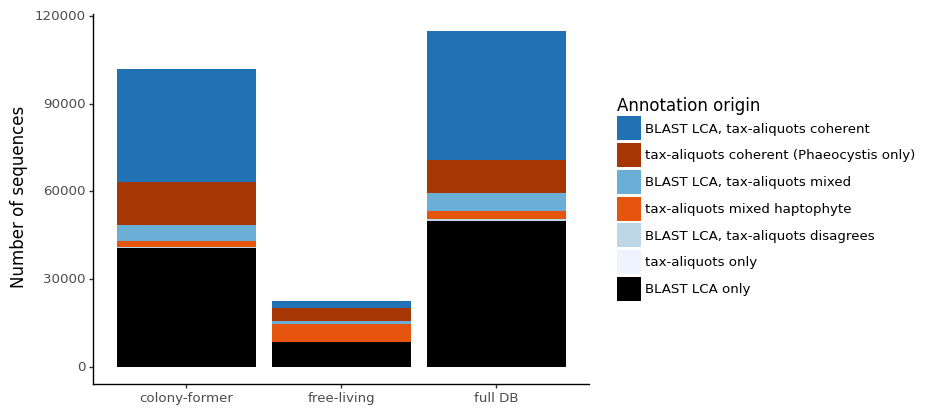

<ggplot: (2932429890967)>

In [66]:
phaeo_plot

In [15]:
top_abundant=["Phaeocystis","Unclassified"]
for_sankey["Genus"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["Genus"]]
for_sankey["FreeGenus"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["FreeGenus"]]
for_sankey["ColonyGenus"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant) else "Other"\
                              for curr in for_sankey["ColonyGenus"]]
for_sankey["Combined_Annotation_EUKulele"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant)|(check_in_haptophyta(curr.split("_"))) else "Other"\
                              for curr in for_sankey["Combined_Annotation_EUKulele"]]
for_sankey["Combined_Annotation_EUKulele_all"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant)|(check_in_haptophyta(curr.split("_"))) else "Other"\
                              for curr in for_sankey["Combined_Annotation_EUKulele_all"]]
for_sankey["Combined_Annotation_EUKulele_colony"] = ["Unclassified" if (curr=="")|(curr=="NoDeepClustWTarget")|(curr=="Indeterminate")\
                              else curr if (curr in top_abundant)|(check_in_haptophyta(curr.split("_"))) else "Other"\
                              for curr in for_sankey["Combined_Annotation_EUKulele_colony"]]

for_sankey["Combined_Annotation_EUKulele"] = ["Phaeocystis and other haptophytes" if ("Phaeocystis" in curr)&\
                                              ("_" in curr) else curr for curr in for_sankey["Combined_Annotation_EUKulele"]]
for_sankey["Combined_Annotation_EUKulele_all"] = ["Phaeocystis and other haptophytes" if ("Phaeocystis" in curr)&\
                                              ("_" in curr) else curr for curr in for_sankey["Combined_Annotation_EUKulele_all"]]
for_sankey["Combined_Annotation_EUKulele_colony"] = ["Phaeocystis and other haptophytes" if ("Phaeocystis" in curr)&\
                                              ("_" in curr) else curr for curr in for_sankey["Combined_Annotation_EUKulele_colony"]]

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: phaeo_tax_aliquots.pdf
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/

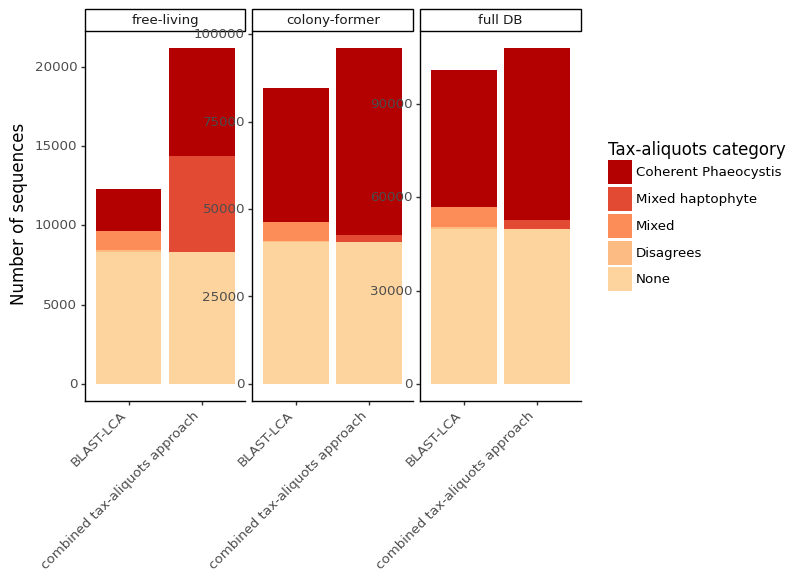

<ggplot: (2932462992378)>

In [120]:
final_summary_all=for_sankey.groupby(["Genus","Combined_Annotation_EUKulele_all",
                                               "Annotation origin all"]).\
           transcript_name.sum().reset_index().\
           rename({"Annotation origin all":"Annotation origin"},axis="columns")
final_summary_all["type"] = "full DB"

final_summary_free = for_sankey.groupby(["FreeGenus","Combined_Annotation_EUKulele","Annotation origin free"]).\
           transcript_name.sum().reset_index().rename({"Annotation origin free":"Annotation origin",
                                                       "Combined_Annotation_EUKulele":"Combined_Annotation_EUKulele_all"},\
                                                      axis="columns")
final_summary_free["type"] = "free-living"


final_summary_colony = for_sankey.groupby(["ColonyGenus","Combined_Annotation_EUKulele_colony","Annotation origin colony"]).\
           transcript_name.sum().reset_index().rename({"Annotation origin colony":"Annotation origin",
                                                       "Combined_Annotation_EUKulele_colony":"Combined_Annotation_EUKulele_all"},\
                                                      axis="columns")
final_summary_colony["type"] = "colony-former"

concat_bars = pd.concat([final_summary_all,final_summary_free,final_summary_colony])
concat_bars["Annotation origin"] = ["tax-aliquots, Phaeocystis & other haptophytes" if curr=="Phaeocystis and other haptophytes"\
                                    else "tax-aliquots, Phaeocystis only" if (curr=="Phaeocystis")&(origin=="tax-aliquots")\
                                    else origin for curr,origin in zip(concat_bars["Combined_Annotation_EUKulele_all"],
                                                                            concat_bars["Annotation origin"])]


concat_bars["Has BLAST-LCA"] = ["Yes" if "BLAST LCA" in curr else "No" for curr in\
                                concat_bars["Annotation origin"]]
concat_bars["Tax-aliquots"] = ["None" if "tax-aliquots" not in curr else \
                               "Mixed haptophyte" if "other haptophytes" in curr else \
                               "Mixed" if ("tax-aliquots mixed" in curr)|(curr=="tax-aliquots") else \
                               "Coherent Phaeocystis" if ("tax-aliquots coherent" in curr)|\
                                ("Phaeocystis only" in curr) else \
                                "Disagrees" if ("disagrees" in curr) else curr for curr in \
                                concat_bars["Annotation origin"]]
concat_bars["Tax-aliquots cat"]=pd.Categorical(concat_bars["Tax-aliquots"],
                                           categories=["Coherent Phaeocystis",
                                                       "Mixed haptophyte",
                                                       "Mixed",
                                                       "Disagrees",
                                                       "None"])


concat_bars["Annotation origin"]=pd.Categorical(concat_bars["Annotation origin"],
               categories=["BLAST LCA, tax-aliquots coherent",
                           "tax-aliquots, Phaeocystis only",
                           "BLAST LCA, tax-aliquots mixed",
                           "tax-aliquots, Phaeocystis & other haptophytes",
                           "BLAST LCA, tax-aliquots disagrees",
                           "tax-aliquots",
                           "BLAST LCA"])

concat_bars["combinedx"]=[curr+" no BLAST-LCA" if "BLAST LCA" in annotorigin \
                          else curr+" BLAST-LCA" for curr,annotorigin in\
                          zip(concat_bars["type"],concat_bars["Annotation origin"])]
#in panel B from bottom: ochrophyte, diatom, tax aliquots w no label, coherent. 
    
phaeo_plot = (plotnine.ggplot(concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                                  concat_bars.Combined_Annotation_EUKulele_all]])+
               plotnine.geom_bar(plotnine.aes(x="type",y="transcript_name",fill="Annotation origin"),
                                 stat="identity") + plotnine.theme_classic(base_size=12) + plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") + \
    plotnine.scale_fill_manual(values=["#2171b5","#a63603","#6baed6","#e6550d","#bdd7e7","#eff3ff"],
                               #"#CC5500","#F28C28","#DAA06D","#F2D2BD","#F0FFFF","#89CFF0"],
                               labels=["BLAST LCA, tax-aliquots coherent",
                           "tax-aliquots coherent (Phaeocystis only)",
                           "BLAST LCA, tax-aliquots mixed",
                           "tax-aliquots mixed haptophyte",
                           "BLAST LCA, tax-aliquots disagrees",
                           "tax-aliquots",
                           "BLAST LCA only"]))

phaeo_plot = (plotnine.ggplot(concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                                  concat_bars.Combined_Annotation_EUKulele_all]])+
               plotnine.geom_bar(plotnine.aes(x="combinedx",y="transcript_name",#fill="Annotation origin",
                                              fill="Tax-aliquots cat"),
                                 stat="identity",position="stack") + \
              plotnine.theme_classic(base_size=12) + plotnine.xlab("") + \
    plotnine.geom_text(data=concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                            concat_bars.Combined_Annotation_EUKulele_all]].\
                            groupby(["Has BLAST-LCA","type","combinedx"]).transcript_name.sum().reset_index(),
                       mapping=plotnine.aes(x="combinedx",y="transcript_name",
                                    label="Has BLAST-LCA", group="Has BLAST-LCA"),
              position=plotnine.position_dodge(width=0.5))+
    plotnine.ylab("Number of sequences")+\
    plotnine.scale_fill_manual(values=["#b2df8a","#a6cee3","#1f78b4",
                                       "#33a02c","#fb9a99","#e31a1c"],
                               name="Tax-aliquots category")+
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1))+
    plotnine.geom_vline(xintercept = 1.5))

concat_bars["Assessment category"] = [["BLAST-LCA"] if \
                                      ("BLAST LCA" in annotorigin)&\
                                      (("disagrees" in annotorigin)|("mixed" in annotorigin)) else\
                                      ["BLAST-LCA","combined tax-aliquots approach"] if ("BLAST LCA" in annotorigin) else \
                                      ["combined tax-aliquots approach"] for annotorigin \
                                      in concat_bars["Annotation origin"]]

for_plot = concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                            concat_bars.Combined_Annotation_EUKulele_all]].explode("Assessment category")

for_plot["type_cat"]=pd.Categorical(for_plot["type"],
                                           categories=["free-living","colony-former","full DB"])

phaeo_plot = (plotnine.ggplot(for_plot)+
               plotnine.geom_bar(plotnine.aes(x="Assessment category",
                                              y="transcript_name",#fill="Annotation origin",
                                              fill="Tax-aliquots cat"),
                                 stat="identity",position="stack") + \
              plotnine.theme_classic(base_size=12) + plotnine.xlab("") +
    plotnine.ylab("Number of sequences")+\
    plotnine.scale_fill_manual(values=["#b30000","#e34a33","#fc8d59",
                                       "#fdbb84","#fdd49e"],
                               name="Tax-aliquots category")+
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1))+
    plotnine.facet_wrap("type_cat",scales="free_y"))
#fdd49e
#fdbb84
#fc8d59
#e34a33
#b30000
                                       
phaeo_plot.save("phaeo_tax_aliquots.pdf")
phaeo_plot

In [100]:
concat_bars["Assessment category"] = [["BLAST-LCA"] if \
                                      ("BLAST LCA" in annotorigin)&\
                                      (("disagrees" in annotorigin)|("mixed" in annotorigin)) else\
                                      ["BLAST-LCA","tax-aliquots"] for annotorigin \
                                      in concat_bars["Annotation origin"]]

In [90]:
concat_bars.loc[["Phaeocystis" in str(curr) for curr in \
                            concat_bars.Combined_Annotation_EUKulele_all]].\
                            groupby(["Has BLAST-LCA","type"]).transcript_name.sum().reset_index()

,Has BLAST-LCA,type,transcript_name
0,No,colony-former,17110
1,No,free-living,10243
2,No,full DB,14015
3,Yes,colony-former,84763
4,Yes,free-living,12307
5,Yes,full DB,100887


## Read in eggNOG-mapper data

In [21]:
eggnog_mapper = pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/eggnog-tara-phaeo/phaeo_eggnog_mapper/SO-all-SRF-0.8-5.00.emapper.annotations",
            comment="#",usecols=[0,20],sep="\t",header=None,names=["query","PFAMs"])

In [23]:
eggnog_mapper.head()

,query,PFAMs
0,k119_128_1,Sulfatase
1,k119_175_1,"Glutaredoxin,Thioredoxin"
2,k119_183_1,"Sulfotransfer_3,TPR_1,TPR_11,TPR_12,TPR_16,TPR..."
3,k119_243_1,"Utp13,WD40"
4,k119_247_1,Kinesin


### Let's explore improvements provided by tax-aliquots

In [36]:
merged_info=merged_w_eukulele0_5_hapto[["transcript_name","Genus|agg","Genus"]].\
    merge(eggnog_mapper,left_on="transcript_name",right_on="query",how="outer")
merged_info=merged_info.loc[merged_info.transcript_name==merged_info.transcript_name]
merged_info["Genus|agg"] = ["NoHomClust" if curr!=curr else curr for curr in merged_info["Genus|agg"]]
merged_info["PFAMs"] = ["NoPFAM" if curr!=curr else "hasPFAM" for curr in merged_info["PFAMs"]]
merged_info["Cluster_Type"] = ["Phaeocystis" if curr=="Phaeocystis" else \
                               "Phaeocystis_Pavlova"  if curr=="Pavlova|Phaeocystis" else \
                               "ContainsPhaeocystis" if "Phaeocystis" in curr \
                               else "NoDeepClustWTarget" if curr == "NoDeepClustWTarget" else \
                               "NoHomClust" if curr == "NoHomClust" else "NonPhaeoCluster" \
                               for curr in merged_info["Genus|agg"]]

In [43]:
merged_info.drop_duplicates(subset=["transcript_name","Cluster_Type","Genus","PFAMs",
                     "Genus|agg"]).groupby(["Cluster_Type","Genus","PFAMs",
                     "Genus|agg"])["transcript_name"].count().reset_index().\
    sort_values("transcript_name",ascending=False).head(n=30)

,Cluster_Type,Genus,PFAMs,Genus|agg,transcript_name
1884,NoDeepClustWTarget,Unclassified,NoPFAM,NoDeepClustWTarget,1083061
7637,NonPhaeoCluster,Unclassified,hasPFAM,,320195
1885,NoDeepClustWTarget,Unclassified,hasPFAM,NoDeepClustWTarget,247026
7449,NonPhaeoCluster,Unclassified,NoPFAM,,97708
13834,Phaeocystis,Phaeocystis,hasPFAM,Phaeocystis,22237
13833,Phaeocystis,Phaeocystis,NoPFAM,Phaeocystis,21911
1748,NoDeepClustWTarget,Phaeocystis,NoPFAM,NoDeepClustWTarget,19607
5402,NonPhaeoCluster,Phaeocystis,NoPFAM,,12087
5426,NonPhaeoCluster,Phaeocystis,hasPFAM,,11980
1616,NoDeepClustWTarget,Florenciella,NoPFAM,NoDeepClustWTarget,7471


In [29]:
merged_w_eukulele0_5_hapto.loc[merged_w_eukulele0_5_hapto.transcript_name!=\
                               merged_w_eukulele0_5_hapto.transcript_name,
                              ["Revised_name","transcript_name","Genus|agg","Genus"]]

,Revised_name,transcript_name,Genus|agg,Genus
2019510,P_antarctica_caron,NaN,Pavlova_Phaeocystis,Unclassified
2019511,P_antarctica_caron,NaN,Pavlova_Phaeocystis,Unclassified
2019512,P_antarctica_caron,NaN,Phaeocystis,Unclassified
2019513,P_antarctica_caron,NaN,Phaeocystis,Unclassified
2019514,P_antarctica_caron,NaN,Phaeocystis,Unclassified
...,...,...,...,...
10313325,MMETSP0223,NaN,Akashiwo,Unclassified
10313326,MMETSP0223,NaN,Akashiwo_Gyrodinium_Prorocentrum_Pyrocystis_Th...,Unclassified
10313327,MMETSP0223,NaN,Akashiwo_Karenia_Prorocentrum_Symbiodinium,Unclassified
10313328,MMETSP0223,NaN,Akashiwo_Karenia_Prorocentrum_Symbiodinium,Unclassified


In [27]:
merged_w_eukulele0_5_hapto.columns

Index(['Unnamed: 0', 'transcript_name', 'classification_level',
       'full_classification', 'classification', 'max_pid', 'ambiguous',
       'counts', 'Domain', 'Division', 'Phylum', 'Class', 'Order', 'Family',
       'Genus', 'Species', 'Revised_name', 'HomClust', 'cluster_blob',
       'Division|set', 'Division|lenset', 'Division|len', 'Division|sum',
       'Domain|set', 'Domain|lenset', 'Domain|len', 'Domain|sum', 'Family|set',
       'Family|lenset', 'Family|len', 'Family|sum', 'Class|set',
       'Class|lenset', 'Class|len', 'Class|sum', 'sample_code|set',
       'sample_code|lenset', 'sample_code|len', 'sample_code|sum', 'Genus|set',
       'Genus|lenset', 'Genus|len', 'Genus|sum', 'Species|set',
       'Species|lenset', 'Species|len', 'Species|sum', 'Family|agg',
       'Genus|agg', 'Species|agg', 'Division|agg'],
      dtype='object')

### Let's explore improvements provided by tax-aliquots for the colony-forming database

In [70]:
merged_info_free=merged_w_eukulele0_5_hapto[["transcript_name","Genus|agg","Genus","Species|agg"]].\
    merge(merged_2,left_on="transcript_name",right_on="transcript_name",how="outer").\
    merge(eggnog_mapper,left_on="transcript_name",right_on="query",how="outer")
merged_info_free=merged_info_free.loc[merged_info_free.transcript_name==merged_info_free.transcript_name]
merged_info_free["Genus|agg"] = ["NoHomClust" if curr!=curr else curr for curr in merged_info_free["Genus|agg"]]
merged_info_free["PFAMs"] = ["NoPFAM" if curr!=curr else "hasPFAM" for curr in merged_info_free["PFAMs"]]
merged_info_free["Cluster_Type"] = ["Phaeocystis" if curr=="Phaeocystis" else \
                               "Phaeocystis_Pavlova"  if curr=="Pavlova|Phaeocystis" else \
                               "ContainsPhaeocystis" if "Phaeocystis" in curr \
                               else "NoDeepClustWTarget" if curr == "NoDeepClustWTarget" else \
                               "NoHomClust" if curr == "NoHomClust" else "NonPhaeoCluster" \
                               for curr in merged_info_free["Genus|agg"]]

In [52]:
merged_info_free.head()

,transcript_name,Genus|agg,Genus,FreeDivision,FreeClass,FreeFamily,FreeGenus,FreeSpecies,query,PFAMs,Cluster_Type
0,k119_100014_1,NoDeepClustWTarget,Unclassified,Stramenopiles,Bacillariophyta,Bacillariaceae,Unclassified,None,NaN,NoPFAM,NoDeepClustWTarget
1,k119_100057_1,Jannaschia_Octadecabacter_Roseibacterium,Unclassified,Proteobacteria,Alphaproteobacteria,Rhodobacteraceae,Unclassified,None,k119_100057_1,hasPFAM,NonPhaeoCluster
2,k119_100077_1,,Paraglaciecola,Proteobacteria,Gammaproteobacteria,Alteromonadaceae,Paraglaciecola,None,k119_100077_1,hasPFAM,NonPhaeoCluster
3,k119_10008_1,Phaeocystis_Pinguiococcus,Phaeocystis,None,Unclassified,None,Unclassified,None,k119_10008_1,hasPFAM,ContainsPhaeocystis
4,k119_100090_1,,Aureococcus,Stramenopiles,Pelagophyceae,Pelagomonadaceae,Aureococcus,None,k119_100090_1,hasPFAM,NonPhaeoCluster


In [71]:
merged_info_free.drop_duplicates(subset=["transcript_name","Cluster_Type","FreeGenus","PFAMs","Genus","Species|agg",
                     "Genus|agg"]).groupby(["Cluster_Type","FreeGenus","Genus","PFAMs","Species|agg",
                     "Genus|agg"])["transcript_name"].count().reset_index().\
    sort_values("transcript_name",ascending=False).head(n=30)

,Cluster_Type,FreeGenus,Genus,PFAMs,Species|agg,Genus|agg,transcript_name
3601,NoDeepClustWTarget,Unclassified,Unclassified,NoPFAM,NoDeepClustWTarget,NoDeepClustWTarget,1082891
10873,NonPhaeoCluster,Unclassified,Unclassified,hasPFAM,,,319992
3602,NoDeepClustWTarget,Unclassified,Unclassified,hasPFAM,NoDeepClustWTarget,NoDeepClustWTarget,246923
10620,NonPhaeoCluster,Unclassified,Unclassified,NoPFAM,,,97558
3598,NoDeepClustWTarget,Unclassified,Phaeocystis,NoPFAM,NoDeepClustWTarget,NoDeepClustWTarget,17793
10494,NonPhaeoCluster,Unclassified,Phaeocystis,NoPFAM,,,11167
10516,NonPhaeoCluster,Unclassified,Phaeocystis,hasPFAM,,,9776
3280,NoDeepClustWTarget,Florenciella,Florenciella,NoPFAM,NoDeepClustWTarget,NoDeepClustWTarget,7471
18777,Phaeocystis,Unclassified,Phaeocystis,NoPFAM,Phaeocystis antarctica,Phaeocystis,6254
3599,NoDeepClustWTarget,Unclassified,Phaeocystis,hasPFAM,NoDeepClustWTarget,NoDeepClustWTarget,4697


In [101]:
merged_ctd=merged_info_free.drop_duplicates(subset=["transcript_name","Cluster_Type","FreeGenus","PFAMs","Genus",
                                                    "Species|agg",
                     "Genus|agg"]).groupby(["Cluster_Type","FreeGenus","Genus","PFAMs","Species|agg",
                     "Genus|agg"])["transcript_name"].count().reset_index().\
    sort_values("transcript_name",ascending=False)

merged_ctd["FL_Lifestyle"] = ["free-living" if (("jahnii" in curr)|("rex" in curr)|("cordata" in curr)) & \
                           ("Phaeocystis" in curr_phaeo) \
                           else "NA" \
                for curr,curr_phaeo in zip(merged_ctd["Species|agg"],merged_ctd["Genus|agg"])]

merged_ctd["CF_Lifestyle"] = ["colony-former" if \
                           (("antarctica" in curr)|("globosa" in curr)|("pouchetii" in curr)) & \
                           ("Phaeocystis" in curr_phaeo) else "NA" \
                for curr,curr_phaeo in zip(merged_ctd["Species|agg"],merged_ctd["Genus|agg"])]

In [108]:
## we're looking for cases where EUKulele annotated Phaeocystis at the genus level, and
## tax-aliquots may or may not have, while the free-living database left it unannotated.
to_examine = merged_ctd.groupby(["Cluster_Type","PFAMs","CF_Lifestyle","FL_Lifestyle",
                                 "Genus","FreeGenus","Genus|agg"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

to_examine.loc[(to_examine.Genus=="Phaeocystis")&(to_examine.FreeGenus=="Unclassified")]

,Cluster_Type,PFAMs,CF_Lifestyle,FL_Lifestyle,Genus,FreeGenus,Genus|agg,transcript_name
14537,Phaeocystis,NoPFAM,colony-former,NA,Phaeocystis,Unclassified,Phaeocystis,20049
1989,NoDeepClustWTarget,NoPFAM,NA,NA,Phaeocystis,Unclassified,NoDeepClustWTarget,17793
14605,Phaeocystis,hasPFAM,colony-former,NA,Phaeocystis,Unclassified,Phaeocystis,16472
2588,NonPhaeoCluster,NoPFAM,NA,NA,Phaeocystis,Unclassified,,11167
6311,NonPhaeoCluster,hasPFAM,NA,NA,Phaeocystis,Unclassified,,9776
...,...,...,...,...,...,...,...,...
2594,NonPhaeoCluster,NoPFAM,NA,NA,Phaeocystis,Unclassified,Crustomastix,1
2592,NonPhaeoCluster,NoPFAM,NA,NA,Phaeocystis,Unclassified,Chrysoreinhardia,1
2591,NonPhaeoCluster,NoPFAM,NA,NA,Phaeocystis,Unclassified,Chrysochromulina_Pavlova,1
2605,NonPhaeoCluster,NoPFAM,NA,NA,Phaeocystis,Unclassified,Scyphosphaera,1


In [114]:
to_examine.loc[(to_examine.Genus=="Phaeocystis")&(to_examine.FreeGenus=="Unclassified")&\
               (to_examine.FL_Lifestyle=="free-living")].groupby(["Cluster_Type","Genus|agg"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,Cluster_Type,Genus|agg,transcript_name
223,ContainsPhaeocystis,Pavlova_Phaeocystis,3187
238,Phaeocystis,Phaeocystis,2550
174,ContainsPhaeocystis,Chrysochromulina_Phaeocystis,46
169,ContainsPhaeocystis,Chrysochromulina_Pavlova_Phaeocystis,40
38,ContainsPhaeocystis,Calcidiscus_Chrysochromulina_Chrysotila_Coccol...,19
...,...,...,...
104,ContainsPhaeocystis,Calcidiscus_Phaeocystis_Prymnesium_Scyphosphaera,1
105,ContainsPhaeocystis,Ceratium_Chrysochromulina_Coccolithus_Dicrater...,1
106,ContainsPhaeocystis,Ceratium_Phaeocystis_Rhodomonas,1
107,ContainsPhaeocystis,Chlamydomonas_Dicrateria_Dunaliella_Exanthemac...,1


In [112]:
to_examine.loc[(to_examine.Genus=="Phaeocystis")&(to_examine.FreeGenus=="Unclassified")&\
               (to_examine.FL_Lifestyle=="free-living")].groupby(["Cluster_Type","PFAMs"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,Cluster_Type,PFAMs,transcript_name
1,ContainsPhaeocystis,hasPFAM,2854
3,Phaeocystis,hasPFAM,1970
0,ContainsPhaeocystis,NoPFAM,916
2,Phaeocystis,NoPFAM,580


In [97]:
to_examine.loc[(to_examine.Genus=="Phaeocystis")|(to_examine.FreeGenus=="Phaeocystis")|\
               (to_examine["Cluster_Type"]=="Phaeocystis")].\
    groupby(["FreeGenus","Genus","Cluster_Type"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False).head(n=50)

,FreeGenus,Genus,Cluster_Type,transcript_name
144,Unclassified,Phaeocystis,Phaeocystis,39336
142,Unclassified,Phaeocystis,NoDeepClustWTarget,22490
143,Unclassified,Phaeocystis,NonPhaeoCluster,21312
145,Unclassified,Unclassified,Phaeocystis,11105
141,Unclassified,Phaeocystis,ContainsPhaeocystis,4655
104,Phaeocystis,Phaeocystis,Phaeocystis,4484
103,Phaeocystis,Phaeocystis,NonPhaeoCluster,3026
102,Phaeocystis,Phaeocystis,NoDeepClustWTarget,2986
101,Phaeocystis,Phaeocystis,ContainsPhaeocystis,1326
107,Phaeocystis,Unclassified,NonPhaeoCluster,196


In [92]:
## how many total sequences are originally annotated as Phaeocystis
to_examine.groupby("Genus").transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,Genus,transcript_name
355,Unclassified,1805415
242,Phaeocystis,100879
128,Florenciella,16228
200,Micromonas,15554
229,Paraglaciecola,8161
...,...,...
109,Elphidiella,1
117,Exanthemachrysis,1
123,Filomicrobium,1
286,Rivularia,1


In [91]:
to_examine.loc[(to_examine.Cluster_Type=="Phaeocystis")&(to_examine.Genus=="Phaeocystis")]

,Cluster_Type,PFAMs,Lifestyle,Genus,FreeGenus,transcript_name
1176,Phaeocystis,NoPFAM,colony-former,Phaeocystis,Unclassified,20049
1234,Phaeocystis,hasPFAM,colony-former,Phaeocystis,Unclassified,16472
1253,Phaeocystis,hasPFAM,free-living,Phaeocystis,Phaeocystis,2066
1255,Phaeocystis,hasPFAM,free-living,Phaeocystis,Unclassified,1970
1225,Phaeocystis,hasPFAM,colony-former,Phaeocystis,Phaeocystis,1357
1188,Phaeocystis,NoPFAM,free-living,Phaeocystis,Unclassified,580
1173,Phaeocystis,NoPFAM,colony-former,Phaeocystis,Phaeocystis,535
1187,Phaeocystis,NoPFAM,free-living,Phaeocystis,Phaeocystis,495
1196,Phaeocystis,hasPFAM,NA,Phaeocystis,Unclassified,140
1154,Phaeocystis,NoPFAM,NA,Phaeocystis,Unclassified,125


### Let's explore improvements made by tax-aliquots for the colony-former database

In [122]:
merged_info_colony=merged_w_eukulele0_5_hapto[["transcript_name","Genus|agg","Genus","Species|agg"]].\
    merge(merged_colony,left_on="transcript_name",right_on="transcript_name",how="outer").\
    merge(eggnog_mapper,left_on="transcript_name",right_on="query",how="outer")
merged_info_colony=merged_info_colony.loc[merged_info_colony.transcript_name==merged_info_colony.transcript_name]
merged_info_colony["Genus|agg"] = ["NoHomClust" if curr!=curr else curr for curr in merged_info_colony["Genus|agg"]]
merged_info_colony["PFAMs"] = ["NoPFAM" if curr!=curr else "hasPFAM" for curr in merged_info_colony["PFAMs"]]
merged_info_colony["Cluster_Type"] = ["Phaeocystis" if curr=="Phaeocystis" else \
                               "Phaeocystis_Pavlova"  if curr=="Pavlova|Phaeocystis" else \
                               "ContainsPhaeocystis" if "Phaeocystis" in curr \
                               else "NoDeepClustWTarget" if curr == "NoDeepClustWTarget" else \
                               "NoHomClust" if curr == "NoHomClust" else "NonPhaeoCluster" \
                               for curr in merged_info_colony["Genus|agg"]]

In [123]:
merged_ctd_colony=merged_info_colony.drop_duplicates(subset=["transcript_name","Cluster_Type",
                                                             "ColonyGenus","PFAMs","Genus",
                                                    "Species|agg",
                     "Genus|agg"]).groupby(["Cluster_Type","ColonyGenus","Genus","PFAMs","Species|agg",
                     "Genus|agg"])["transcript_name"].count().reset_index().\
    sort_values("transcript_name",ascending=False)

merged_ctd_colony["FL_Lifestyle"] = ["free-living" if (("jahnii" in curr)|("rex" in curr)|("cordata" in curr)) & \
                           ("Phaeocystis" in curr_phaeo) \
                           else "NA" \
                for curr,curr_phaeo in zip(merged_ctd_colony["Species|agg"],merged_ctd_colony["Genus|agg"])]

merged_ctd_colony["CF_Lifestyle"] = ["colony-former" if \
                           (("antarctica" in curr)|("globosa" in curr)|("pouchetii" in curr)) & \
                           ("Phaeocystis" in curr_phaeo) else "NA" \
                for curr,curr_phaeo in zip(merged_ctd_colony["Species|agg"],merged_ctd_colony["Genus|agg"])]

In [124]:
## we're looking for cases where EUKulele annotated Phaeocystis at the genus level, and
## tax-aliquots may or may not have, while the free-living database left it unannotated.
to_examine_colony = merged_ctd_colony.groupby(["Cluster_Type","PFAMs","CF_Lifestyle","FL_Lifestyle",
                                 "Genus","ColonyGenus","Genus|agg"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

In [128]:
to_examine_colony.loc[(to_examine_colony.Genus=="Phaeocystis")&(to_examine_colony.ColonyGenus=="Unclassified")&\
               (to_examine_colony.CF_Lifestyle=="colony-former")].groupby(["Cluster_Type","Genus|agg"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,Cluster_Type,Genus|agg,transcript_name
79,Phaeocystis,Phaeocystis,5762
70,ContainsPhaeocystis,Pavlova_Phaeocystis,208
42,ContainsPhaeocystis,Chrysochromulina_Phaeocystis,22
20,ContainsPhaeocystis,Calcidiscus_Phaeocystis,8
78,ContainsPhaeocystis,Phaeocystis_Scyphosphaera,7
...,...,...,...
36,ContainsPhaeocystis,Chrysochromulina_Isochrysis_Pavlova_Phaeocysti...,1
38,ContainsPhaeocystis,Chrysochromulina_Karlodinium_Pelagomonadales_X...,1
41,ContainsPhaeocystis,Chrysochromulina_Peridinium_Phaeocystis,1
43,ContainsPhaeocystis,Chrysochromulina_Phaeocystis_Prymnesium_Scypho...,1


In [135]:
to_examine_colony.loc[(to_examine_colony.Genus=="Phaeocystis")&
                      (to_examine_colony.ColonyGenus=="Unclassified")&\
               (to_examine_colony.CF_Lifestyle=="colony-former")].groupby(["Cluster_Type"]).\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,Cluster_Type,transcript_name
1,Phaeocystis,5762
0,ContainsPhaeocystis,366


In [140]:
to_examine_colony.groupby("ColonyGenus").transcript_name.sum().reset_index().\
    sort_values("transcript_name",ascending=False)

,ColonyGenus,transcript_name
357,Unclassified,1818659
243,Phaeocystis,86098
129,Florenciella,16231
201,Micromonas,15555
230,Paraglaciecola,8161
...,...,...
124,Filomicrobium,1
288,Rivularia,1
133,Gallaecimonas,1
148,Halobacteriovorax,1
